In [37]:
import os
os.chdir("/home/nguyenhieu/UNI/")

In [23]:
import torch
import torchvision
from os.path import join as j_
from PIL import Image
import pandas as pd
import numpy as np

# loading all packages here to start
from uni import get_encoder
from uni.downstream.extract_patch_features import extract_patch_features_from_dataloader
from uni.downstream.eval_patch_features.linear_probe import eval_linear_probe
from uni.downstream.eval_patch_features.fewshot import eval_knn, eval_fewshot
from uni.downstream.eval_patch_features.protonet import ProtoNet, prototype_topk_vote
from uni.downstream.eval_patch_features.metrics import get_eval_metrics, print_metrics
from uni.downstream.utils import concat_images
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Downloading UNI weights + Creating Model

Method 1: Following authentication (using ```huggingface_hub```), the ViT-L/16 model architecture with pretrained weights and image transforms for UNI can be directly loaded using the [timm](https://huggingface.co/docs/hub/en/timm) library. This method automatically downloads the model weights to the [huggingface_hub cache](https://huggingface.co/docs/huggingface_hub/en/guides/manage-cache) in your home directory (```~/.cache/huggingface/hub/models--MahmoodLab--UNI2-h```), which ```timm``` will automatically find when using the commands below:

In [ ]:
import timm
from timm.data import resolve_data_config
from timm.data.transforms_factory import create_transform
from huggingface_hub import login

from dotenv import load_dotenv

load_dotenv()
login(token=os.getenv("HF_TOKEN_UNI"))
  # login with your User Access Token, found at https://huggingface.co/settings/tokens

# pretrained=True needed to load UNI weights (and download weights for the first time)
# init_values need to be passed in to successfully load LayerScale parameters (e.g. - block.0.ls1.gamma)
model = timm.create_model(
    "hf-hub:MahmoodLab/UNI2-h", 
    pretrained=True, init_values=1e-5, 
    dynamic_img_size=True
)
transform = create_transform(**resolve_data_config(
    model.pretrained_cfg, 
    model=model
))
model.eval()
model.to(device)
transform

Method 2: You can also download the model weights to a specified checkpoint location in your local directory. The ```timm``` library is still used for defining the ViT-L/16 model architecture. Pretrained weights and image transforms for UNI need to be manually loaded and defined.


In [ ]:
import os
import torch
from torchvision import transforms
import timm
from huggingface_hub import login, hf_hub_download

from dotenv import load_dotenv

load_dotenv()
login(token=os.getenv("HF_TOKEN_UNI"))
# login with your User Access Token, found at https://huggingface.co/settings/tokens

local_dir = "../assets/ckpts/uni2-h/"
local_dir = "assets/ckpts/uni2-h" # NOTE

os.makedirs(local_dir, exist_ok=True)  # create directory if it does not exist
hf_hub_download("MahmoodLab/UNI2-h", filename="pytorch_model.bin", local_dir=local_dir, force_download=True)
timm_kwargs = {'img_size': 224, 
               'patch_size': 14, 
               'depth': 24,
               'num_heads': 24,
               'init_values': 1e-5, 
               'embed_dim': 1536,
               'mlp_ratio': 2.66667*2,
               'num_classes': 0, 
               'no_embed_class': True,
               'mlp_layer': timm.layers.SwiGLUPacked, 
               'act_layer': torch.nn.SiLU, 
               'reg_tokens': 8, 
               'dynamic_img_size': True
              }
model = timm.create_model(**timm_kwargs)
model.load_state_dict(torch.load(os.path.join(local_dir, "pytorch_model.bin"), map_location="cpu"), strict=True)
model.eval()
model.to(device)
transform = transforms.Compose(
    [
        transforms.Resize(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ]
)
transform

The function `get_encoder` performs the commands above, downloading in the checkpoint in the `./assets/ckpts/` relative path of this GitHub repository.

In [28]:
from uni import get_encoder
model, transform = get_encoder(enc_name='uni2-h', device=device)

### Inference embeddings (from README)

In [38]:
from PIL import Image
image = Image.open(".github/uni.jpg")
image = transform(image).unsqueeze(dim=0) # Image (torch.Tensor) with shape [1, 3, 224, 224] following image resizing and normalization (ImageNet parameters)
with torch.inference_mode():
    feature_emb = model(image) # Extracted features (torch.Tensor) with shape [1, 1536]

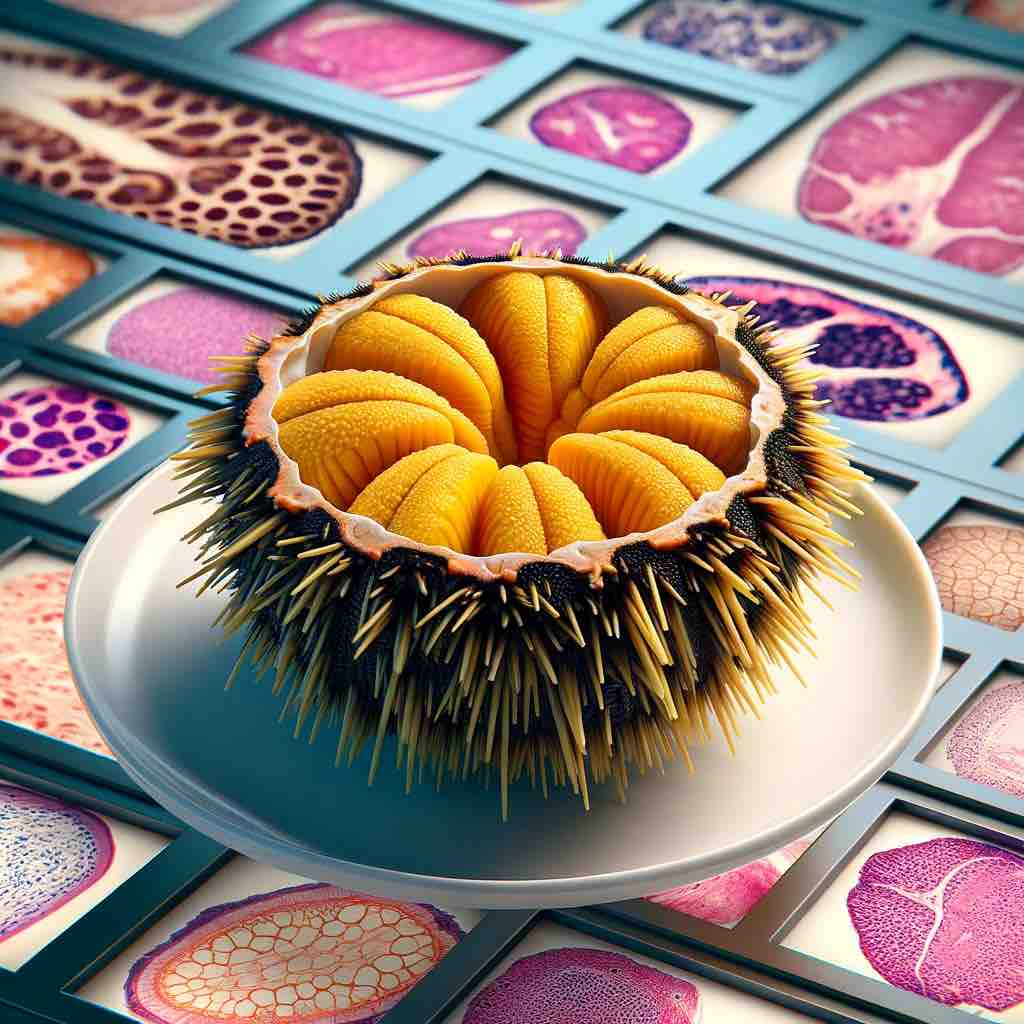

In [45]:
Image.open(".github/uni.jpg")

In [44]:
print(feature_emb)
print(feature_emb.shape)
print(min(feature_emb.flatten()), max(feature_emb.flatten()))

tensor([[ 0.5641, -0.7036, -0.7597,  ..., -0.2251, -0.0919,  0.6956]])
torch.Size([1, 1536])
tensor(-1.3993) tensor(1.4835)


### ROI Feature Extraction

In [49]:
from uni.downstream.extract_patch_features import extract_patch_features_from_dataloader

# get path to example data
dataroot = 'assets/data/tcga_luadlusc/tcga_luadlusc'

# create some image folder datasets for train/test and their data laoders
train_dataset = torchvision.datasets.ImageFolder(j_(dataroot, 'train'), transform=transform)
test_dataset = torchvision.datasets.ImageFolder(j_(dataroot, 'test'), transform=transform)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=4, shuffle=False)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=4, shuffle=False)

# extract patch features from the train and test datasets (returns dictionary of embeddings and labels)
train_features = extract_patch_features_from_dataloader(model, train_dataloader)
test_features = extract_patch_features_from_dataloader(model, test_dataloader)

# convert these to torch
train_feats = torch.Tensor(train_features['embeddings'])
train_labels = torch.Tensor(train_features['labels']).type(torch.long)
test_feats = torch.Tensor(test_features['embeddings'])
test_labels = torch.Tensor(test_features['labels']).type(torch.long)

  0%|          | 0/33 [00:00<?, ?it/s]

100%|██████████| 15/15 [42:13<00:00, 168.92s/it]


/home/nguyenhieu/.conda/envs/UNI/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


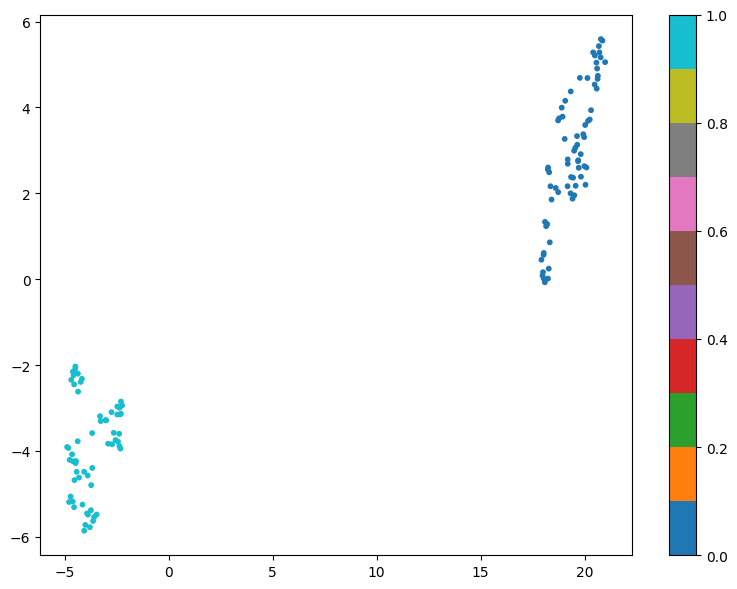

In [59]:
import umap.umap_ as umap
import matplotlib.pyplot as plt

# reduce to 2D, default UMAP parameters
umap_model = umap.UMAP(n_components=2)
train_umap = umap_model.fit_transform(train_feats)

plt.figure(figsize=(8, 6))
scatter = plt.scatter(train_umap[:, 0], train_umap[:, 1], c=train_labels, cmap='tab10', s=10)
plt.colorbar(scatter)
plt.tight_layout()
plt.show()

### ROI Linear Probe Evaluation.

In [60]:
from uni.downstream.eval_patch_features.linear_probe import eval_linear_probe

linprobe_eval_metrics, linprobe_dump = eval_linear_probe(
    train_feats = train_feats,
    train_labels = train_labels,
    valid_feats = None ,
    valid_labels = None,
    test_feats = test_feats,
    test_labels = test_labels,
    max_iter = 1000,
    verbose= True,
)

print_metrics(linprobe_eval_metrics)

Linear Probe Evaluation: Train shape torch.Size([130, 1536])
Linear Probe Evaluation: Test shape torch.Size([60, 1536])
Linear Probe Evaluation (Train Time): Best cost = 30.720
Linear Probe Evaluation (Train Time): Using only train set for evaluation. Train Shape:  torch.Size([130, 1536])
(Before Training) Loss: 0.693
(After Training) Loss: 0.016
Linear Probe Evaluation (Test Time): Test Shape torch.Size([60, 1536])
Linear Probe Evaluation: Time taken 30.63
Test lin_acc: 1.000
Test lin_bacc: 1.000
Test lin_kappa: 1.000
Test lin_weighted_f1: 1.000
Test lin_auroc: 1.000


### ROI KNN and ProtoNet evaluation.

In [61]:
from uni.downstream.eval_patch_features.fewshot import eval_knn

knn_eval_metrics, knn_dump, proto_eval_metrics, proto_dump = eval_knn(
    train_feats = train_feats,
    train_labels = train_labels,
    test_feats = test_feats,
    test_labels = test_labels,
    center_feats = True,
    normalize_feats = True,
    n_neighbors = 20
)

print_metrics(knn_eval_metrics)
print_metrics(proto_eval_metrics)

Test knn20_acc: 1.000
Test knn20_bacc: 1.000
Test knn20_kappa: 1.000
Test knn20_weighted_f1: 1.000
Test proto_acc: 1.000
Test proto_bacc: 1.000
Test proto_kappa: 1.000
Test proto_weighted_f1: 1.000


### ROI Few-Shot Evaluation (based on ProtoNet)

In [62]:
from uni.downstream.eval_patch_features.fewshot import eval_fewshot

fewshot_episodes, fewshot_dump = eval_fewshot(
    train_feats = train_feats,
    train_labels = train_labels,
    test_feats = test_feats,
    test_labels = test_labels,
    n_iter = 500, # draw 500 few-shot episodes
    n_way = 2, # use all class examples
    n_shot = 4, # 4 examples per class (as we don't have that many)
    n_query = test_feats.shape[0], # evaluate on all test samples
    center_feats = True,
    normalize_feats = True,
    average_feats = True,
)

# how well we did picking 4 random examples per class
display(fewshot_episodes)

# summary
display(fewshot_dump)

100%|██████████| 500/500 [17:25<00:00,  2.09s/it]


,Kw4s_acc,Kw4s_bacc,Kw4s_kappa,Kw4s_weighted_f1
0,0.916667,0.916667,0.833333,0.916084
1,0.683333,0.683333,0.366667,0.648040
2,1.000000,1.000000,1.000000,1.000000
3,1.000000,1.000000,1.000000,1.000000
4,1.000000,1.000000,1.000000,1.000000
...,...,...,...,...
495,1.000000,1.000000,1.000000,1.000000
496,1.000000,1.000000,1.000000,1.000000
497,1.000000,1.000000,1.000000,1.000000
498,1.000000,1.000000,1.000000,1.000000


{'Kw4s_acc_avg': np.float64(0.9361333333333334),
 'Kw4s_bacc_avg': np.float64(0.9361333333333334),
 'Kw4s_kappa_avg': np.float64(0.8722666666666666),
 'Kw4s_weighted_f1_avg': np.float64(0.9289430547276676),
 'Kw4s_acc_std': np.float64(0.11577791069441998),
 'Kw4s_bacc_std': np.float64(0.11577791069441998),
 'Kw4s_kappa_std': np.float64(0.23155582138883996),
 'Kw4s_weighted_f1_std': np.float64(0.13624201632231203)}

### A Closer Look at ProtoNet

You can use ProtoNet in a sklearn-like API as well for fitting and predicting models.

In [ ]:
from uni.downstream.eval_patch_features.protonet import ProtoNet

# fitting the model
proto_clf = ProtoNet(metric='L2', center_feats=True, normalize_feats=True)
proto_clf.fit(train_feats, train_labels)
print('What our prototypes look like', proto_clf.prototype_embeddings.shape)

# evaluating the model
test_pred = proto_clf.predict(test_feats)
get_eval_metrics(test_labels, test_pred, get_report=False)

Using `proto_clf._get_topk_queries_inds`, we use the test samples as the query set, and get the top-k queries to each prototype, effectively doing ROI retrieval.

In [ ]:
dist, topk_inds = proto_clf._get_topk_queries_inds(test_feats, topk=5)
print('label2idx correspondenes', train_dataset.class_to_idx)
test_imgs_df = pd.DataFrame(test_dataset.imgs, columns=['path', 'label'])

print('Top-k LUAD-like test samples to LUAD prototype')
luad_topk_inds = topk_inds[0]
luad_topk_imgs = concat_images([Image.open(img_fpath) for img_fpath in test_imgs_df['path'][luad_topk_inds]], scale=0.5)
display(luad_topk_imgs)

print('Top-k LUSC-like test samples to LUSC prototype')
lusc_topk_inds = topk_inds[1]
lusc_topk_imgs = concat_images([Image.open(img_fpath) for img_fpath in test_imgs_df['path'][lusc_topk_inds]], scale=0.5)
display(lusc_topk_imgs)

Using `proto_clf._get_topk_prototypes_inds`, we can instead use the prototypes as the query set, and get the top-k queries to each test sample. With k set to # of prototypes / labels, we are essentially doing ROI classification (assigning label of the nearest prototype to the test sample).

In [ ]:
dist, topk_inds = proto_clf._get_topk_prototypes_inds(test_feats, topk=2)
print("The top-2 closest prototypes to each test sample, with closer prototypes first (left hand side)")
display(topk_inds)

print('Labels of the top-1 closest prototypes')
pred_test = topk_inds[:, 0]